# Estudo Comparativo de Modelos de Séries Temporais Nebulosas

[<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">](https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode)
Autores: Leonardo Ferreira (leauferreira@gmail.com) e Petrônio Silva (petronio.candido@gmail.com)



* [Revisão De Literatura](https://www.overleaf.com/read/hqxnrtmtvygh)

* [Apresentação](https://www.overleaf.com/read/hnhzmgfgbndv)


## Índice

1. [Importações Comuns](#Importações-Comuns)
2. [Dados de Treinamento e Validação](#Dados-de-Treinamento-e-Validação)
3. [Códigos Comuns](#Códigos-Comuns)
   1. [Funções de Pertinência](#Funções-de-Pertinência)
   2. [Conjuntos Nebulosos](#Conjuntos-Nebulosos)
   3. [Particionadores do Universo de Discurso](#Particionadores-do-Universo-de-Discurso)
3. [First Order Fuzzy Time Series](#First-Order-Fuzzy-Time-Series)
4. [High Order Fuzzy Time Series](#High-Order-Fuzzy-Time-Series)
5. [Weighted Fuzzy Time Series]()
6. [Comparação entre os modelos]()
7. [Referências]()

## Importações Comuns

In [59]:
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Dados de Treinamento e Validação

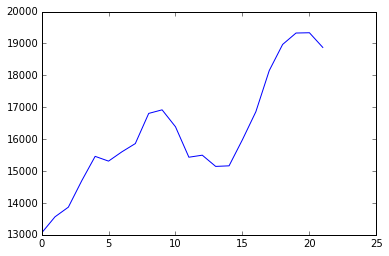

In [60]:
enrollments = pd.read_csv("/home/petronio/dados/Dropbox/Doutorado/Disciplinas/SistemasNebulosos/TrabalhoFinal/DataSets/Enrollments.csv", sep=";")

plot(enrollments["Enrollments"])

## Códigos Comuns

### Funções de Pertinência

In [2]:
def trimf(x,parameters):
	if(x < parameters[0]):
		return 0
	elif(x >= parameters[0] and x < parameters[1]):
		return (x-parameters[0])/(parameters[1]-parameters[0])
	elif(x >= parameters[1] and x <= parameters[2]):
		return (parameters[2]-x)/(parameters[2]-parameters[1])
	else: 
		return 0

def trapmf(x, parameters):
		if(x < parameters[0]):
			return 0
		elif(x >= parameters[0] and x < parameters[1]):
			return (x-parameters[0])/(parameters[1]-parameters[0])
		elif(x >= parameters[1] and x <= parameters[2]):
			return 1
		elif(x >= parameters[2] and x <= parameters[3]):
			return (parameters[3]-x)/(parameters[3]-parameters[2])
		else: 
			return 0

def gaussmf(x,parameters):
		return math.exp(-0.5*((x-parameters[0]) / parameters[1] )**2)


def bellmf(x,parameters):
		return 1 / (1 + abs((xx - parameters[2])/parameters[0])**(2*parameters[1]))


def sigmf(x,parameters):
		return 1 / (1 + math.exp(-parameters[0] * (x - parameters[1])))


### Conjuntos Nebulosos

In [19]:
class FuzzySet:

	def __init__(self,name,mf,parameters,centroid):
		self.name = name
		self.mf = mf
		self.parameters = parameters
		self.centroid = centroid
        
	def membership(self,x):
		return self.mf(x,self.parameters)
    
	def __str__(self):
		return self.name + ": " + str(self.mf) + "(" + str(self.parameters) + ")"
    
    

### Particionadores do Universo de Discurso

In [14]:
def GridPartitionerTrimf(data,npart,names = None,prefix = "A"):
	sets = []
	dmax = max(data)
	dmin = min(data)
	dlen = dmax - dmin
	partlen = dlen / npart
	partition = dmin
	for c in range(npart):
		sets.append( FuzzySet(prefix+str(c),trimf,[partition-partlen, partition, partition+partlen], partition ) )
		partition = partition + partlen
		
	return sets

In [45]:
sts = GridPartitionerTrimf(enrollments["Enrollments"],10)
for s in sts:
    print(s)

A0: <function trimf at 0xb184a41c>([12426.799999999999, 13055, 13683.200000000001])
A1: <function trimf at 0xb184a41c>([13055.0, 13683.200000000001, 14311.400000000001])
A2: <function trimf at 0xb184a41c>([13683.200000000001, 14311.400000000001, 14939.600000000002])
A3: <function trimf at 0xb184a41c>([14311.400000000001, 14939.600000000002, 15567.800000000003])
A4: <function trimf at 0xb184a41c>([14939.600000000002, 15567.800000000003, 16196.000000000004])
A5: <function trimf at 0xb184a41c>([15567.800000000003, 16196.000000000004, 16824.200000000004])
A6: <function trimf at 0xb184a41c>([16196.000000000004, 16824.200000000004, 17452.400000000005])
A7: <function trimf at 0xb184a41c>([16824.200000000004, 17452.400000000005, 18080.600000000006])
A8: <function trimf at 0xb184a41c>([17452.400000000005, 18080.600000000006, 18708.800000000007])
A9: <function trimf at 0xb184a41c>([18080.600000000006, 18708.800000000007, 19337.000000000007])


# Fuzzy Logical Relationship Group

In [28]:
class FLRG:
	def __init__(self,premiss):
		self.premiss = premiss
		self.consequent = set()
	
	def append(self,c):
		self.consequent.add(c)

	def __str__(self):
		tmp = self.premiss + " -> "
		tmp2 = ""
		for c in self.consequent:
			if len(tmp2) > 0:
				tmp2 = tmp2 + ","
			tmp2 = tmp2 + c
		return tmp + tmp2


In [38]:
flrgx = FLRG("A")
flrgx.append("B")
flrgx.append("C")
print(flrgx)

A -> C,B


# First Order Fuzzy Time Series

In [124]:
class FTS:
	def __init__(self,order):
		self.sets = {}
		self.flrgs = {}
		self.order = order
        
	def fuzzy(self,data):
		best = {"fuzzyset":"", "membership":0.0}

		for f in self.sets:
			fset = self.sets[f]
			if best["membership"] <= fset.membership(data):
				best["fuzzyset"] = fset.name
				best["membership"] = fset.membership(data)

		return best
		
	def defuzzy(self,data):
        
		actual = self.fuzzy(data)
        
		if actual["fuzzyset"] not in self.flrgs:
			return self.sets[actual["fuzzyset"]].centroid

		flrg = self.flrgs[actual["fuzzyset"]]

		count = 0.0
		denom = 0.0

		for s in flrg.consequent:
			denom = denom + self.sets[actual["fuzzyset"]].centroid
			count = count + 1.0

		return denom/count
        
	def learn(self, data, sets):
		last = {"fuzzyset":"", "membership":0.0}
		actual = {"fuzzyset":"", "membership":0.0}
		
		for s in sets:
			self.sets[s.name] = s
		
		self.flrgs = {}
		count = 1
		for inst in data:
			actual = self.fuzzy(inst)
			
			if count > self.order:
				if last["fuzzyset"] not in self.flrgs:
					self.flrgs[last["fuzzyset"]] = FLRG(last["fuzzyset"])
			
				self.flrgs[last["fuzzyset"]].append(actual["fuzzyset"])    
			count = count + 1
			last = actual
	def predict(self,data):
		return self.defuzzy(data)
	def __str__(self):
		s = ""
		for c in self.flrgs:
			s = s + str(self.flrgs[c]) + "\n"
		return s  
	
	def plot(self,original):
		fig = plt.figure(figsize=[20,6])
		predicted = [self.predict(xx) for xx in original]
		plot(original)
		plot(predicted)
		return predicted

In [125]:
sets1 = GridPartitionerTrimf(enrollments["Enrollments"],10)
fts1 = FTS(1)
fts1.learn(enrollments["Enrollments"],sets1)
print(fts1)

A9 -> A9
A8 -> A9
A3 -> A3,A4,A5
A1 -> A3,A1
A5 -> A6,A4
A6 -> A8,A6,A5
A4 -> A6,A4,A3
A0 -> A1



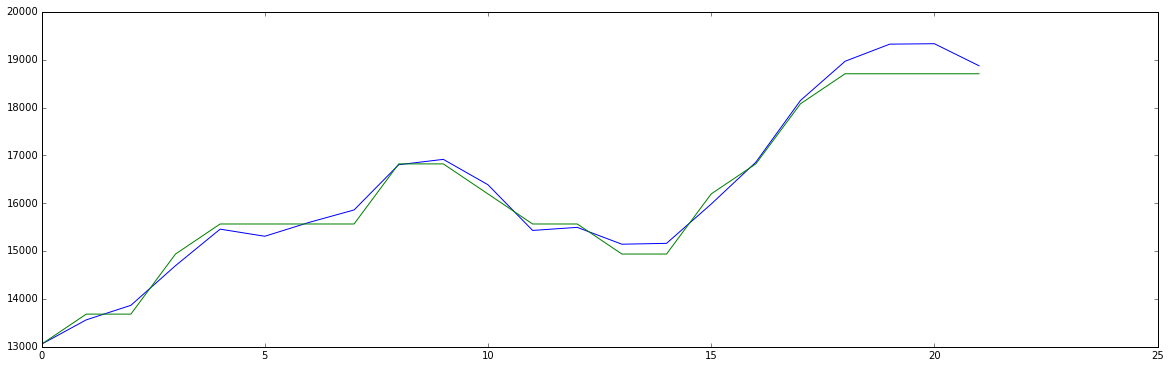

In [132]:
fts1r = fts1.plot(enrollments["Enrollments"])

In [127]:
sets2 = GridPartitionerTrimf(enrollments["Enrollments"],7)
fts2 = FTS(1)
fts2.learn(enrollments["Enrollments"],sets2)
print(fts2)

A3 -> A3,A4,A2
A1 -> A1,A2
A0 -> A1
A6 -> A6,A2
A4 -> A3,A4,A6
A2 -> A3,A6,A2



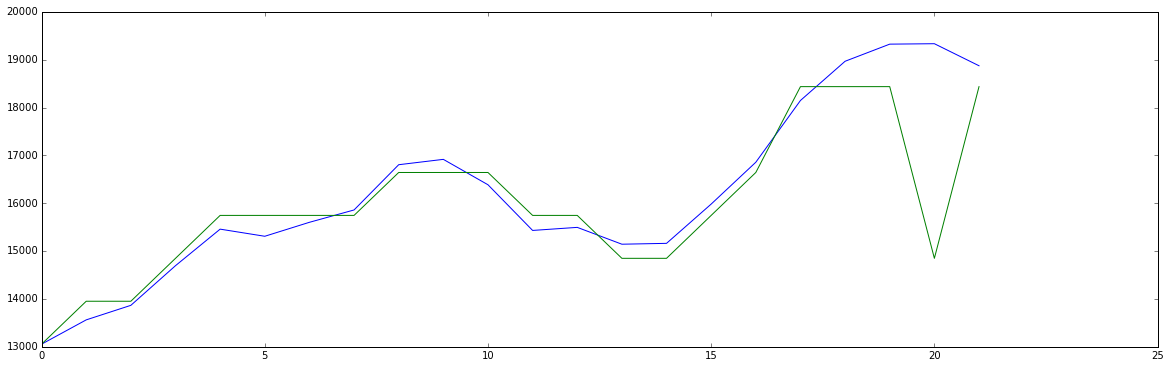

In [133]:
fts2r = fts2.plot(enrollments["Enrollments"])

In [129]:
sets3 = GridPartitionerTrimf(enrollments["Enrollments"],5)
fts3 = FTS(1)
fts3.learn(enrollments["Enrollments"],sets3)
print(fts3)

A3 -> A3,A4,A2
A0 -> A0,A1
A2 -> A3,A2
A1 -> A1,A2
A4 -> A4



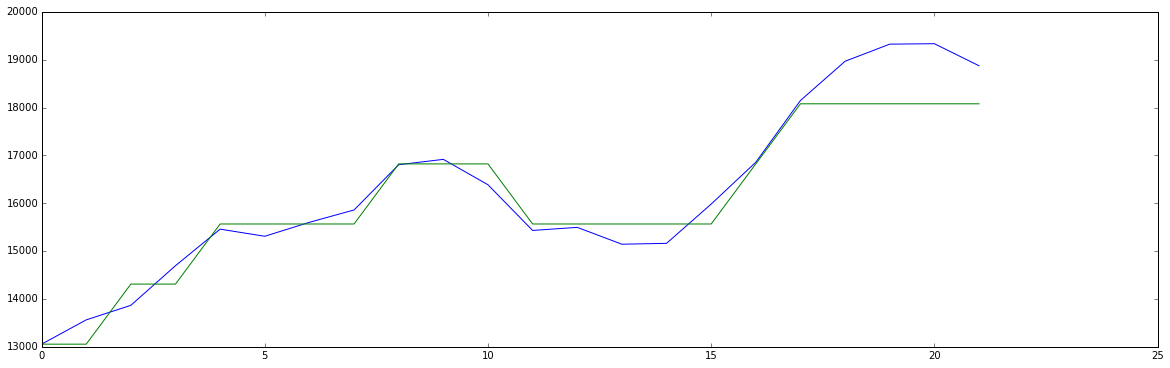

In [134]:
fts3r = fts3.plot(enrollments["Enrollments"])

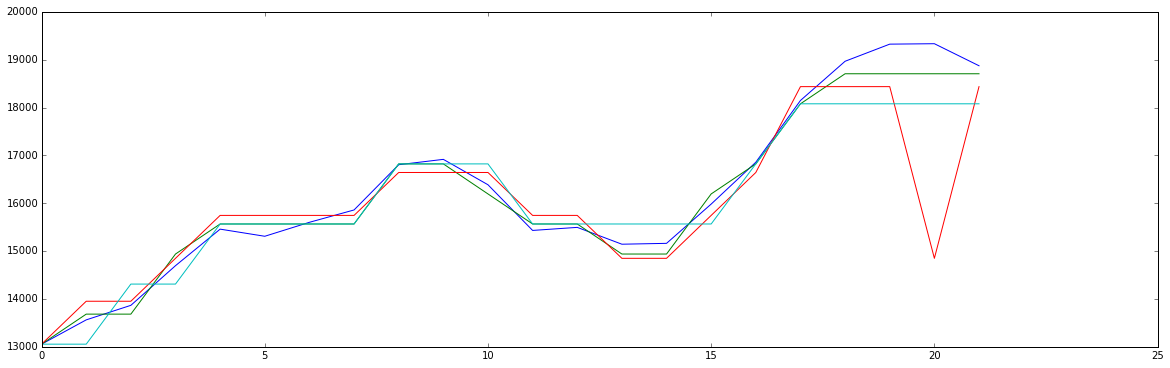

In [135]:
fig = plt.figure(figsize=[20,6])
plot(enrollments["Enrollments"])
plot(fts1r)
plot(fts2r)
plot(fts3r)

# High Order Fuzzy Time Series

In [ ]:
class HighOrderFTS:
	def __init__(self,order):
		self.sets = {}
		self.order = order